# Imports and Data Extraction

In [55]:
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [56]:
import os
import shutil
import random
from PIL import Image
import time
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd

from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d, MaxPool2d, Linear, BatchNorm2d, Dropout

import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import models, datasets, transforms
from torchsummary import summary

from torchcam.methods import GradCAM
from torchvision.transforms.functional import normalize
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/archive.zip -d project_data

Streaming output truncated to the last 5000 lines.
  inflating: project_data/Training/glioma/Tr-gl_0712.jpg  
  inflating: project_data/Training/glioma/Tr-gl_0713.jpg  
  inflating: project_data/Training/glioma/Tr-gl_0714.jpg  
  inflating: project_data/Training/glioma/Tr-gl_0715.jpg  
  inflating: project_data/Training/glioma/Tr-gl_0716.jpg  
  inflating: project_data/Training/glioma/Tr-gl_0717.jpg  
  inflating: project_data/Training/glioma/Tr-gl_0718.jpg  
  inflating: project_data/Training/glioma/Tr-gl_0719.jpg  
  inflating: project_data/Training/glioma/Tr-gl_0720.jpg  
  inflating: project_data/Training/glioma/Tr-gl_0721.jpg  
  inflating: project_data/Training/glioma/Tr-gl_0722.jpg  
  inflating: project_data/Training/glioma/Tr-gl_0723.jpg  
  inflating: project_data/Training/glioma/Tr-gl_0724.jpg  
  inflating: project_data/Training/glioma/Tr-gl_0725.jpg  
  inflating: project_data/Training/glioma/Tr-gl_0726.jpg  
  inflating: project_data/Training/glioma/Tr-gl_0727.jpg  
  inf

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Evaluation device:", device)

Evaluation device: cuda


# Data Preprocessing

In [5]:
def create_val_set(test_dir, new_test_dir, val_dir, split=0.5):
  os.makedirs(new_test_dir, exist_ok=True)
  os.makedirs(val_dir, exist_ok=True)

  print("\nDirectory structure analysis:")
  print(f"Source directory contents ({test_dir}):")
  source_items = os.listdir(test_dir)
  for item in source_items:
    item_path = os.path.join(test_dir, item)
    if os.path.isdir(item_path):
      print(f"  - Directory: {item} (contains {len(os.listdir(item_path))} items)")

  # Look for MRI type directories (e.g., glioma, meningioma, etc.)
  mri_types = []
  for item in source_items:
    item_path = os.path.join(test_dir, item)
    if os.path.isdir(item_path):
      mri_types.append(item)

  if not mri_types:
      print(f"Error: No MRI type directories found in {test_dir}")
      return

  print(f"\nFound {len(mri_types)} MRI types: {mri_types}")

  for mri_type in mri_types:
    mri_path = os.path.join(test_dir, mri_type)
    all_items = os.listdir(mri_path)
    images = []
    for item in all_items:
      item_path = os.path.join(mri_path, item)
      if os.path.isfile(item_path):
        images.append(item)

    if not images:
        print(f"Warning: No image files found in {mri_path}")
        print(f"Contents: {all_items[:10]}{'...' if len(all_items) > 10 else ''}")
        continue

    random.shuffle(images)

    boundary = int(len(images) * split)
    if boundary == 0 and len(images) > 0:
      boundary = 1

    val_images = images[:boundary]
    test_images = images[boundary:]

    print(f"\nMRI type: {mri_type}, Total images: {len(images)}")
    print(f"  - Validation set: {len(val_images)} images")
    print(f"  - Test set: {len(test_images)} images")

    val_dir_mri = os.path.join(val_dir, mri_type)
    new_test_dir_mri = os.path.join(new_test_dir, mri_type)

    os.makedirs(val_dir_mri, exist_ok=True)
    os.makedirs(new_test_dir_mri, exist_ok=True)

    for img in val_images:
      src = os.path.join(mri_path, img)
      dst = os.path.join(val_dir_mri, img)
      try:
        shutil.copy(src, dst)
      except Exception as e:
        print(f"Error copying {src} to {dst}: {e}")

      for img in test_images:
        src = os.path.join(mri_path, img)
        dst = os.path.join(new_test_dir_mri, img)
        try:
          shutil.copy(src, dst)
        except Exception as e:
          print(f"Error copying {src} to {dst}: {e}")

  print("\nData splitting completed!")
  print("\nSummary:")
  print(f"Source directory: {test_dir}")
  print(f"Validation directory: {val_dir}")
  print(f"New test directory: {new_test_dir}")

create_val_set(
  test_dir="project_data/Testing",
  new_test_dir="project_data/UpdatedTest",
  val_dir="project_data/Validation"
)


Directory structure analysis:
Source directory contents (project_data/Testing):
  - Directory: notumor (contains 405 items)
  - Directory: glioma (contains 300 items)
  - Directory: meningioma (contains 306 items)
  - Directory: pituitary (contains 300 items)

Found 4 MRI types: ['notumor', 'glioma', 'meningioma', 'pituitary']

MRI type: notumor, Total images: 405
  - Validation set: 202 images
  - Test set: 203 images

MRI type: glioma, Total images: 300
  - Validation set: 150 images
  - Test set: 150 images

MRI type: meningioma, Total images: 306
  - Validation set: 153 images
  - Test set: 153 images

MRI type: pituitary, Total images: 300
  - Validation set: 150 images
  - Test set: 150 images

Data splitting completed!

Summary:
Source directory: project_data/Testing
Validation directory: project_data/Validation
New test directory: project_data/UpdatedTest


In [31]:
batch_size = 32
seed = 42

In [32]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_ds = datasets.ImageFolder(root="project_data/Training", transform=data_transforms['train'])
val_ds = datasets.ImageFolder(root="project_data/Validation", transform=data_transforms['val'])
test_ds = datasets.ImageFolder(root="project_data/UpdatedTest", transform=data_transforms['test'])

dataloaders = {
    x: DataLoader(
        {'train': train_ds, 'val': val_ds, 'test': test_ds}[x],
        batch_size=batch_size,
        shuffle=(x=="train"),
        num_workers=2,
        pin_memory=True
    )
    for x in ["train", "val", "test"]
}

print('Number of training examples:', len(train_ds))
print('Number of validation examples:', len(val_ds))
print('Number of test examples:', len(test_ds))

class_names = train_ds.classes
print(f"Class names: {class_names}")

Number of training examples: 5712
Number of validation examples: 655
Number of test examples: 656
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


# Model Architecture

In [33]:
img = Image.open("project_data/Training/glioma/Tr-glTr_0000.jpg")
print(img.size)
print(img.mode)

(512, 512)
RGB


In [46]:
class TumorNet(nn.Module):
  def __init__(self, input_dim=224*224, num_outputs=4):
    super(TumorNet, self).__init__()
    self.conv1 = Conv2d(3, 32, 5, padding='same')
    self.conv2 = Conv2d(32, 64, 4, padding='same')
    self.conv3 = Conv2d(64, 128, 3, padding='same')
    self.conv4 = Conv2d(128, 256, 3, padding='same')
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.batch_norm1 = BatchNorm2d(32)
    self.batch_norm2 = BatchNorm2d(64)
    self.batch_norm3 = BatchNorm2d(128)
    self.batch_norm4 = BatchNorm2d(256)
    self.dropout = Dropout(0.45)
    self.fc1 = Linear(256*14*14, 512)
    self.fc2 = Linear(512, num_outputs)


  def forward(self, x):
    x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
    x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
    x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
    x = self.pool(F.relu(self.batch_norm4(self.conv4(x))))
    x = x.view(-1, 256*14*14)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.fc2(x)
    return x

In [48]:
model = TumorNet()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]           2,432
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          32,832
       BatchNorm2d-5         [-1, 64, 112, 112]             128
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
       BatchNorm2d-8          [-1, 128, 56, 56]             256
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
      BatchNorm2d-11          [-1, 256, 28, 28]             512
        MaxPool2d-12          [-1, 256, 14, 14]               0
           Linear-13                  [-1, 512]      25,690,624
          Dropout-14                  [

# Training

In [49]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  start = time.time()
  with TemporaryDirectory() as tempdir:
    best_model_path = os.path.join(tempdir, 'best_model.pth')
    best_acc = 0.0

    patience = 5
    counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
      print(f'Epoch {epoch + 1}/{num_epochs}')
      print('-'*30)
      model.train()
      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      epoch_loss = running_loss / len(dataloaders['train'].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)
      print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      model.eval()
      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      epoch_loss = running_loss / len(dataloaders['val'].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders['val'].dataset)
      print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
      scheduler.step(epoch_loss)
      if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), best_model_path)
      if(epoch_loss < best_val_loss):
        best_val_loss = epoch_loss
        counter = 0
      else:
        counter += 1
        if counter >= patience:
          print(f'Early stopping at epoch {epoch + 1}')
          break
      print('-'*30)
      print('-'*30)
    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(torch.load(best_model_path))
  return model



In [50]:
model = train_model(model, criterion, optimizer, scheduler)
# torch.save(model.state_dict(), "tumor_net.pth")


Epoch 1/25
------------------------------
Train Loss: 0.7250 Acc: 0.7374
Val Loss: 0.5006 Acc: 0.8000
------------------------------
------------------------------
Epoch 2/25
------------------------------
Train Loss: 0.4058 Acc: 0.8428
Val Loss: 0.3354 Acc: 0.8794
------------------------------
------------------------------
Epoch 3/25
------------------------------
Train Loss: 0.3370 Acc: 0.8738
Val Loss: 0.3248 Acc: 0.8794
------------------------------
------------------------------
Epoch 4/25
------------------------------
Train Loss: 0.2668 Acc: 0.8957
Val Loss: 0.2513 Acc: 0.9069
------------------------------
------------------------------
Epoch 5/25
------------------------------
Train Loss: 0.2332 Acc: 0.9118
Val Loss: 0.2398 Acc: 0.9053
------------------------------
------------------------------
Epoch 6/25
------------------------------
Train Loss: 0.1999 Acc: 0.9268
Val Loss: 0.2387 Acc: 0.9130
------------------------------
------------------------------
Epoch 7/25
-----

# Model Evaluation

In [51]:
def eval_model(model, dataloader):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  criterion =  nn.CrossEntropyLoss()

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * inputs.size(0)
      _, preds = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (preds == labels).sum().item()

  test_loss  = running_loss / len(dataloader.dataset)
  test_acc = correct / total
  print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
  return test_loss, test_acc


In [52]:
_, _ = eval_model(model, dataloaders['test'])


Test Loss: 0.0539 Acc: 0.9817


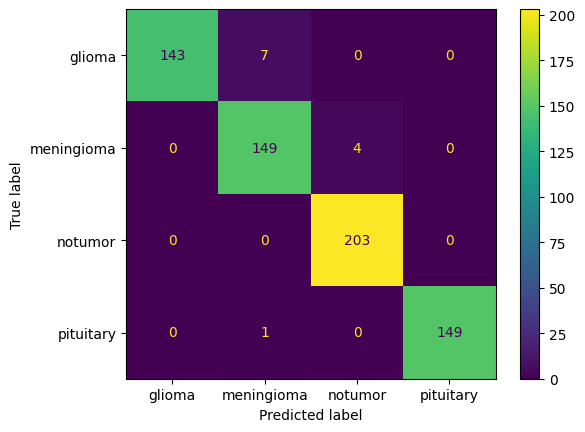

              precision    recall  f1-score   support

      glioma       1.00      0.95      0.98       150
  meningioma       0.95      0.97      0.96       153
     notumor       0.98      1.00      0.99       203
   pituitary       1.00      0.99      1.00       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



In [53]:
test_preds = torch.tensor([], dtype=torch.long, device=device)
test_labels = torch.tensor([], dtype=torch.long, device=device)

with torch.no_grad():
  for images, labels in dataloaders['test']:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    test_preds = torch.cat((test_preds, preds), 0)
    test_labels = torch.cat((test_labels, labels), 0)
ConfusionMatrixDisplay.from_predictions(test_labels.cpu(), test_preds.cpu(), display_labels=class_names)
plt.show()
print(classification_report(test_labels.cpu(), test_preds.cpu(), target_names=class_names))


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

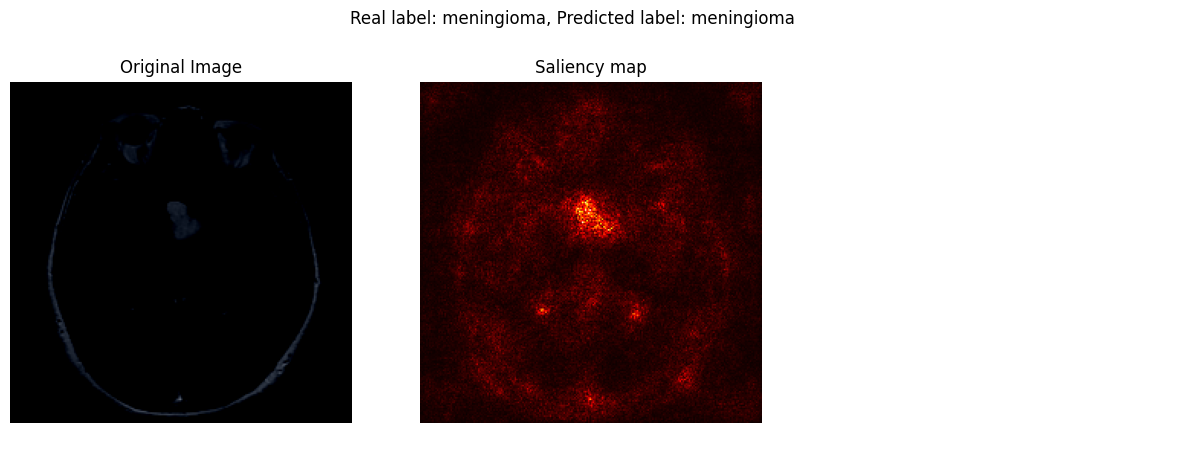

In [107]:
# https://medium.datadriveninvestor.com/visualizing-neural-networks-using-saliency-maps-in-pytorch-289d8e244ab4

index = 250
img = test_ds[index][0].to(device=device)

plt.figure(figsize=(15, 5))
plt.suptitle(f"Real label: {test_ds.classes[test_ds[index][1]]}, Predicted label: {test_ds.classes[test_preds[index]]}")
plt.axis('off')

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

invNorm = transforms.Normalize(mean=[0., 0., 0.], std=[1./std[0], 1./std[1], 1./std[2]])
plt.subplot(1, 3, 1)
plt.imshow(invNorm(img).moveaxis(0, -1).cpu())
plt.title('Original Image')
plt.axis('off')

model.eval()
img = img.unsqueeze(0)
img.requires_grad = True
score, pred = torch.max(model(img), axis=1)
score.backward()
saliency, _ = torch.max(img.grad.abs(), axis=1)
plt.subplot(1, 3, 2)
plt.imshow(saliency.squeeze(0).cpu(), cmap=plt.cm.hot)
plt.title('Saliency map')
plt.axis('off')
